In [1]:
# Analysis of co-occuring words
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import json
import tweepy as tw
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx
import warnings

warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

f = open('/home/pi/twitter_api_creds.json')
creds = json.load(f)
consumer_key = creds['consumer_key']
consumer_secret = creds['consumer_secret']
access_token = creds['access_token']
access_token_secret = creds['access_token_secret']
f.close()

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [2]:
search_term = "#climate+change -filter:retweets"

tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en",
                   since='2018-11-01').items(1000)

# all_tweets = [tweet.text for tweet in tweets]

# all_tweets[:5]

In [3]:
def remove_url(txt):
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url

In [4]:
# Remove URLs
tweets_no_urls = [remove_url(tweet.text) for tweet in tweets]

# Create a sublist of lower case words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Remove collection words
collection_words = ['climatechange', 'climate', 'change']

tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

[nltk_data] Downloading package stopwords to /home/pi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]

# View bigrams for the first tweet
# terms_bigram[0]
# tweets_no_urls[:5]
terms_bigram[0]

[('seems', 'favor'),
 ('favor', 'change.'),
 ('change.', '‘kafkaesque’'),
 ('‘kafkaesque’', 'ferc'),
 ('ferc', 'pipeline'),
 ('pipeline', 'process'),
 ('process', 'needs'),
 ('needs', 'revamp,'),
 ('revamp,', 'court'),
 ('court', 'says'),
 ('says', '(3)'),
 ('(3)', '#climate')]

In [6]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('#climate', '#change'), 46),
 (('#globalwarming', '#climatechange'), 28),
 (('#change', '#climatechange'), 14),
 (('#climate', 'change,'), 14),
 (('#gpwx', '#globalwarming'), 14),
 (('ag', 'racine'), 13),
 (('racine', 'latest'), 13),
 (('latest', 'sue'), 13),
 (('sue', 'exxonmobil,'), 13),
 (('exxonmobil,', 'bp,'), 13),
 (('bp,', 'chevron,'), 13),
 (('chevron,', 'shell'), 13),
 (('#climate', '#climatechange'), 12),
 (('#climate', 'change:'), 11),
 (('conservative', 'podcast'), 11),
 (('podcast', 'takes'), 11),
 (('check', 'ecoright'), 11),
 (('ecoright', 'speaks:…'), 11),
 (('#climate', 'plan'), 10),
 (('finally!', 'conservative'), 10)]

In [7]:
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(#climate, #change)",46
1,"(#globalwarming, #climatechange)",28
2,"(#change, #climatechange)",14
3,"(#climate, change,)",14
4,"(#gpwx, #globalwarming)",14
5,"(ag, racine)",13
6,"(racine, latest)",13
7,"(latest, sue)",13
8,"(sue, exxonmobil,)",13
9,"(exxonmobil,, bp,)",13


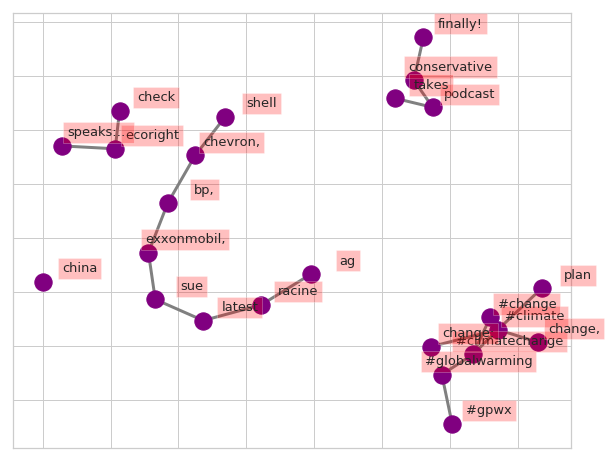

In [8]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("china", weight=100)
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()
